In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import pylab

import warnings
warnings.filterwarnings('ignore')

In [3]:
df_lookback = pd.read_csv('subway_subway_lookback_0301_0331_ALL.csv')

In [4]:
df_lookback.shape

(93081, 12)

In [5]:
df_lookback.head()

,User_ID,Activity_ID,MIN_CONV_TIME,MIN_IMP_TIME,MAX_IMP_TIME,MIN_MIN_DIFF_SEC,MIN_MAX_DIFF_SEC,MIN_MIN_DIFF_DAY,MIN_MAX_DIFF_DAY,Num_of_IMPs_3days,Num_of_IMPs,Activity
0,AMsySZZLcnqcSoloXYaoLdiN_lWl,7094090,2018-03-25 17:40:34.798641,2018-03-25 17:40:25.320193,2018-03-25 17:40:25.320193,9,9,0,0,1,1,Subway.com_Hispanic Homepage_Std
1,AMsySZbfGPZI-qzUkYJkxUEg_wzI,7094090,2018-03-27 15:29:47.579640,2018-03-27 12:27:17.754408,2018-03-27 12:27:17.754408,10950,10950,0,0,1,1,Subway.com_Hispanic Homepage_Std
2,AMsySZYkzd6KUkZjZ87xkm0jJ1M0,7094090,2018-03-23 12:44:49.708569,2018-03-23 12:43:44.278438,2018-03-23 12:43:44.278438,65,65,0,0,1,1,Subway.com_Hispanic Homepage_Std
3,AMsySZb4R_zG5eUZiR--ZIVt5X74,7094090,2018-03-27 11:33:12.506844,2018-03-27 11:24:13.611985,2018-03-27 11:24:52.567154,539,500,0,0,2,2,Subway.com_Hispanic Homepage_Std
4,AMsySZa0Fm921UKn2TSOAUJeN4ci,7094090,2018-03-16 23:49:56.602647,2018-03-16 22:29:28.979057,2018-03-16 23:49:35.670784,4828,21,0,0,3,3,Subway.com_Hispanic Homepage_Std


In [6]:
df_lookback.Activity.value_counts()

Subway.com_Signature Wraps Page_Std                72829
Subway.com_Homepage_Std                             6081
Subway.com_Find a Store - Online Order Page_Std     5781
Subway.com_Hispanic Signature Wraps Page_Std        4991
Subway.com_Online Ordering Homepage_Std             2334
Subway.com_Order Confirmation Page_Std              1037
Subway.com_Hispanic Homepage_Std                      28
Name: Activity, dtype: int64

In [7]:
df_lookback = df_lookback[df_lookback.Activity != 'Subway.com_Hispanic Homepage_Std']

In [8]:
activity_list = df_lookback.Activity.unique().tolist()

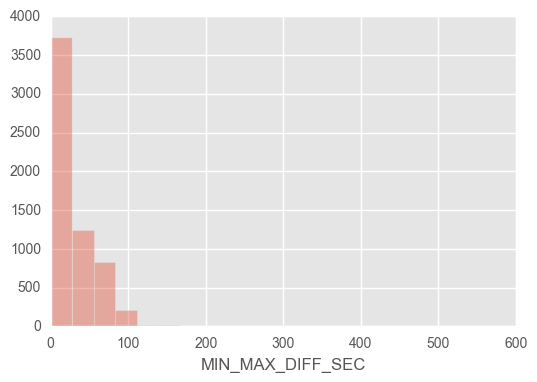

In [9]:
sns.distplot(df_lookback[df_lookback.Activity == 'Subway.com_Homepage_Std'].MIN_MAX_DIFF_SEC/3600, kde=False,bins=20)

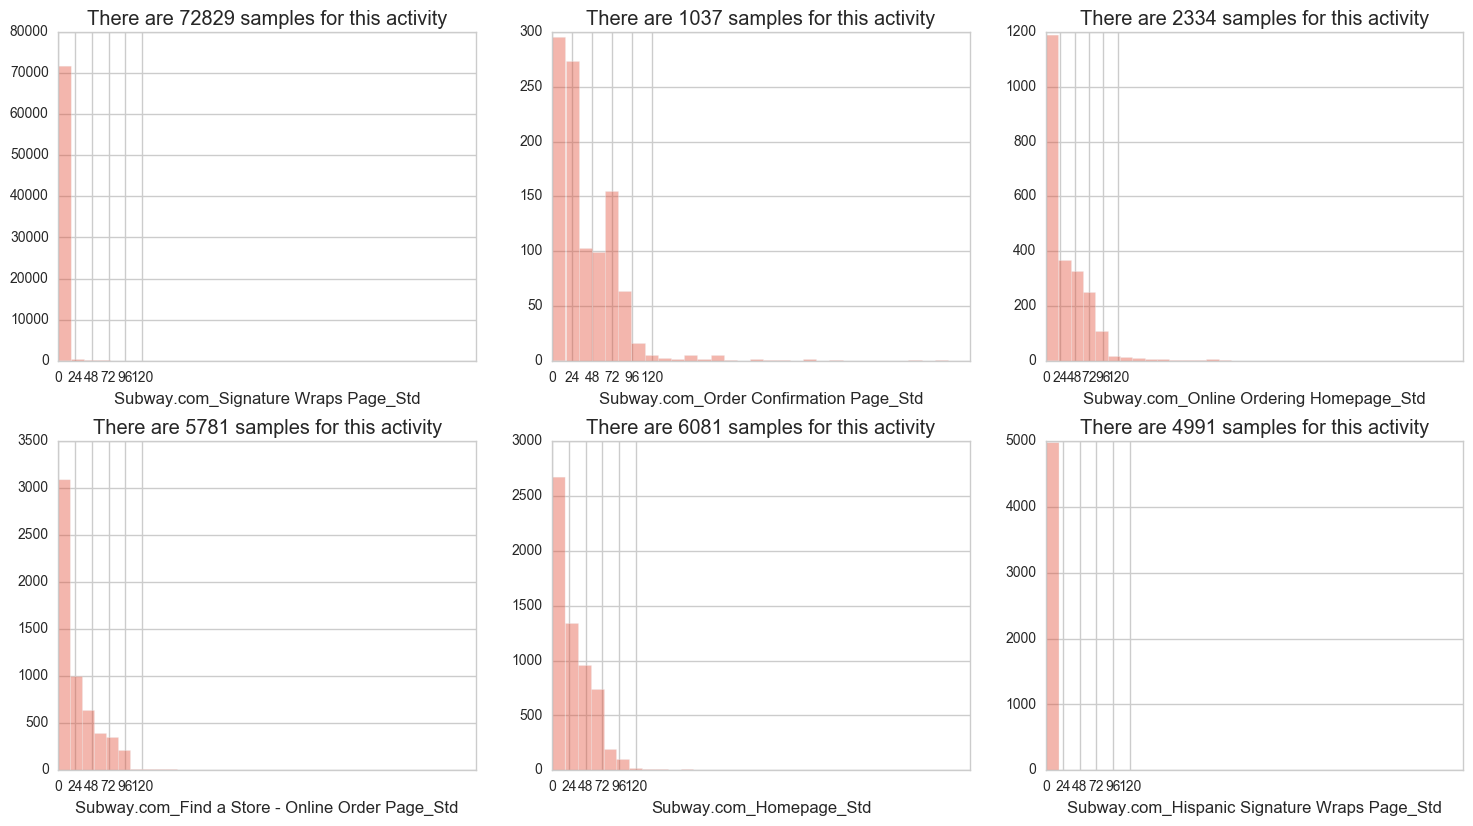

In [46]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(15,12))
    for cnt, act in enumerate(activity_list):
        plt.subplot(3,3,cnt+1)
        sns.distplot(df_lookback[df_lookback.Activity == act].MIN_MAX_DIFF_SEC/3600, kde=False, bins=30)
        plt.title('There are {} samples for this activity'.format((df_lookback.Activity==act).sum()))
        plt.xticks([0, 24, 48, 72, 96, 120])
        plt.xlabel(act)

plt.tight_layout()
plt.savefig('subway_distribution.png')
plt.show()

!pip install lifelines

In [11]:
#df_lookback2 = df_lookback.MIN_MAX_DIFF/60
df_lookback2 = df_lookback.copy()
df_lookback2.MIN_MAX_DIFF_SEC = df_lookback2.MIN_MAX_DIFF_SEC/60
df_lookback2.MIN_MIN_DIFF_SEC = df_lookback2.MIN_MIN_DIFF_SEC/60
df_lookback2['Last_IMP_Converted'] = np.where(df_lookback2.MIN_MAX_DIFF_SEC<=4320, 1, 0)
df_lookback2['First_IMP_Converted'] = np.where(df_lookback2.MIN_MIN_DIFF_SEC<=4320, 1, 0)

In [12]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [13]:
kmf.fit(durations=df_lookback2.MIN_MIN_DIFF_SEC, event_observed=df_lookback2.First_IMP_Converted)

<lifelines.KaplanMeierFitter: fitted with 93053 observations, 27884 censored>

In [39]:
kmf.event_table.head(20)

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.000000,7,7,0,93053,93053
0.016667,67,67,0,0,93046
0.033333,212,212,0,0,92979
0.050000,374,374,0,0,92767
0.066667,481,481,0,0,92393
0.083333,548,548,0,0,91912
0.100000,541,541,0,0,91364
0.116667,605,605,0,0,90823
0.133333,565,565,0,0,90218


In [43]:
kmf.predict([0.3,120])

0.3      0.910180
120.0    0.582143
Name: KM_estimate, dtype: float64

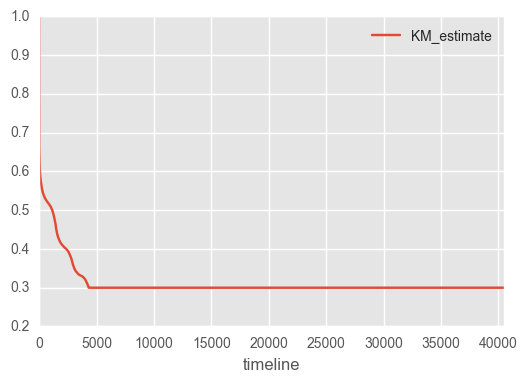

In [16]:
kmf.survival_function_.plot()

In [50]:
# Create KMF Object by Activity Type
def kaplan_plot(d, o,activity_list, df):
    kmf_by_act = KaplanMeierFitter()

    duration = df[d]
    observed = df[o]

    fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(15,10))
    for act, ax in zip(activity_list, axes.flatten()):
        # get indices for players with the matching activity label
        idx = df.Activity == act
        # fit the kmf
        kmf_by_act.fit(duration[idx], observed[idx])
        # plot the KM estimate for that activity
        kmf_by_act.survival_function_.plot(ax=ax, legend=False)
        ax.annotate('Median = {:.0f} mins'.format(kmf_by_act.median_), xy= (.47, .85), xycoords = 'axes fraction')

        # get rid the default 'timeline' x-axis set by kmf plot
        ax.set_xlabel('')
        ax.set_title(act)
        ax.set_xlim(0,8000)
        plt.tight_layout()
    fig.text(-0.01, 0.5, "Probability That a User has not be converted", 
             va="center", rotation="vertical", fontsize=16)
    fig.suptitle("Kaplan Survival Chart by %s" %d, fontsize=20)
    fig.subplots_adjust(top=0.90)
    fig.savefig('Kaplan Survival Chart by {}.png'.format(d))        

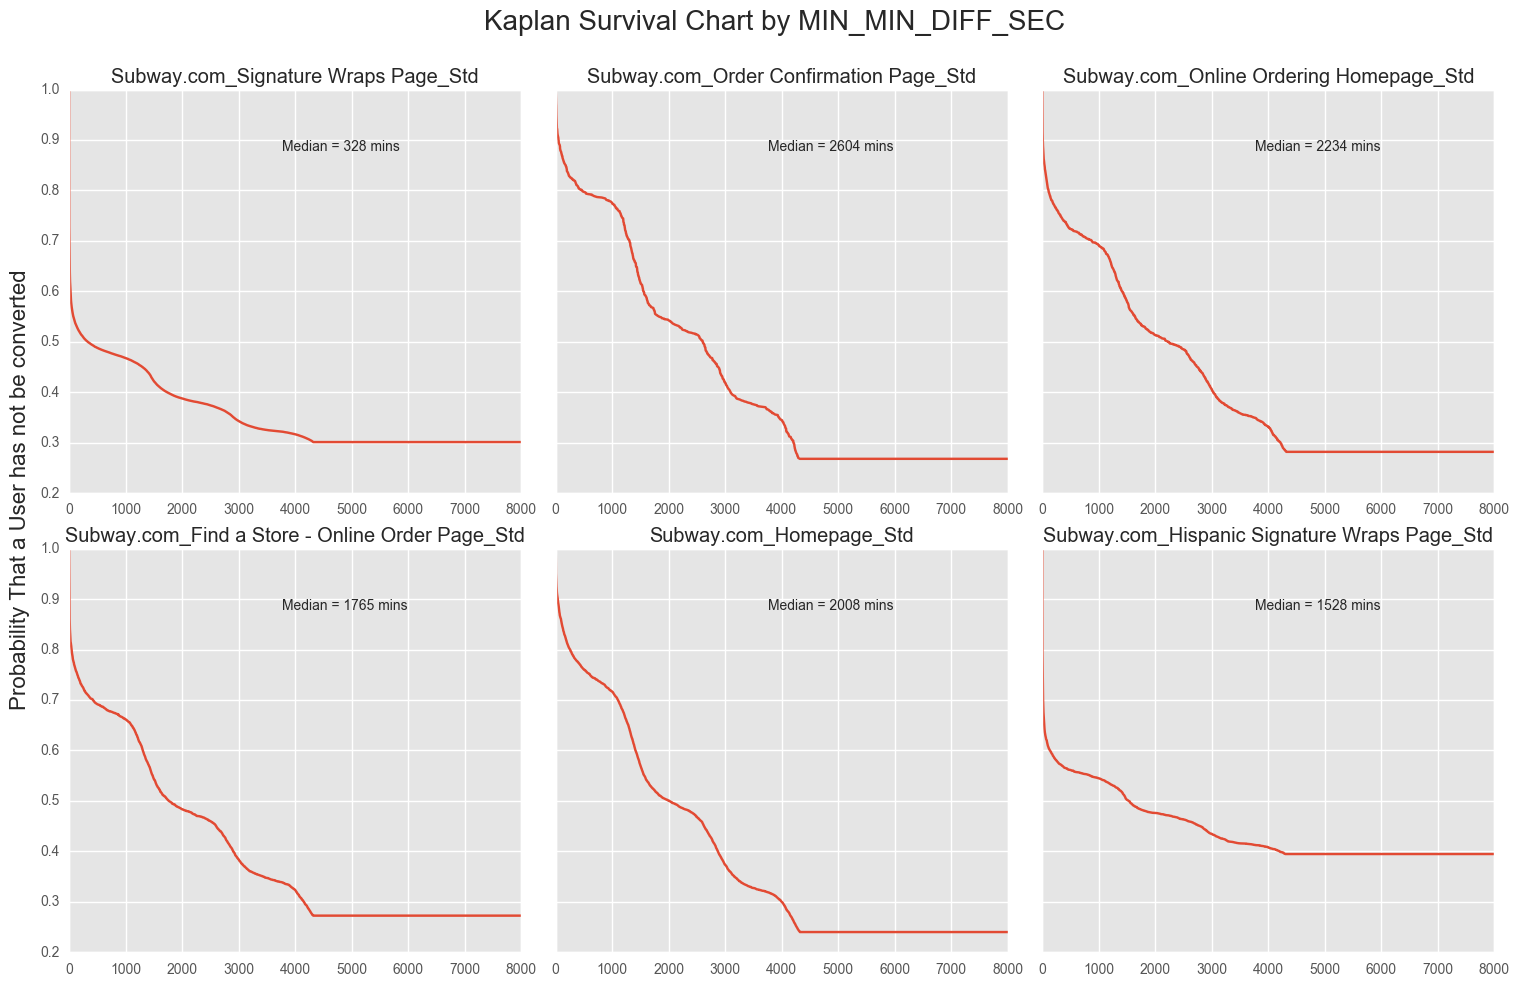

In [51]:
kaplan_plot('MIN_MIN_DIFF_SEC','First_IMP_Converted',activity_list,df_lookback2)

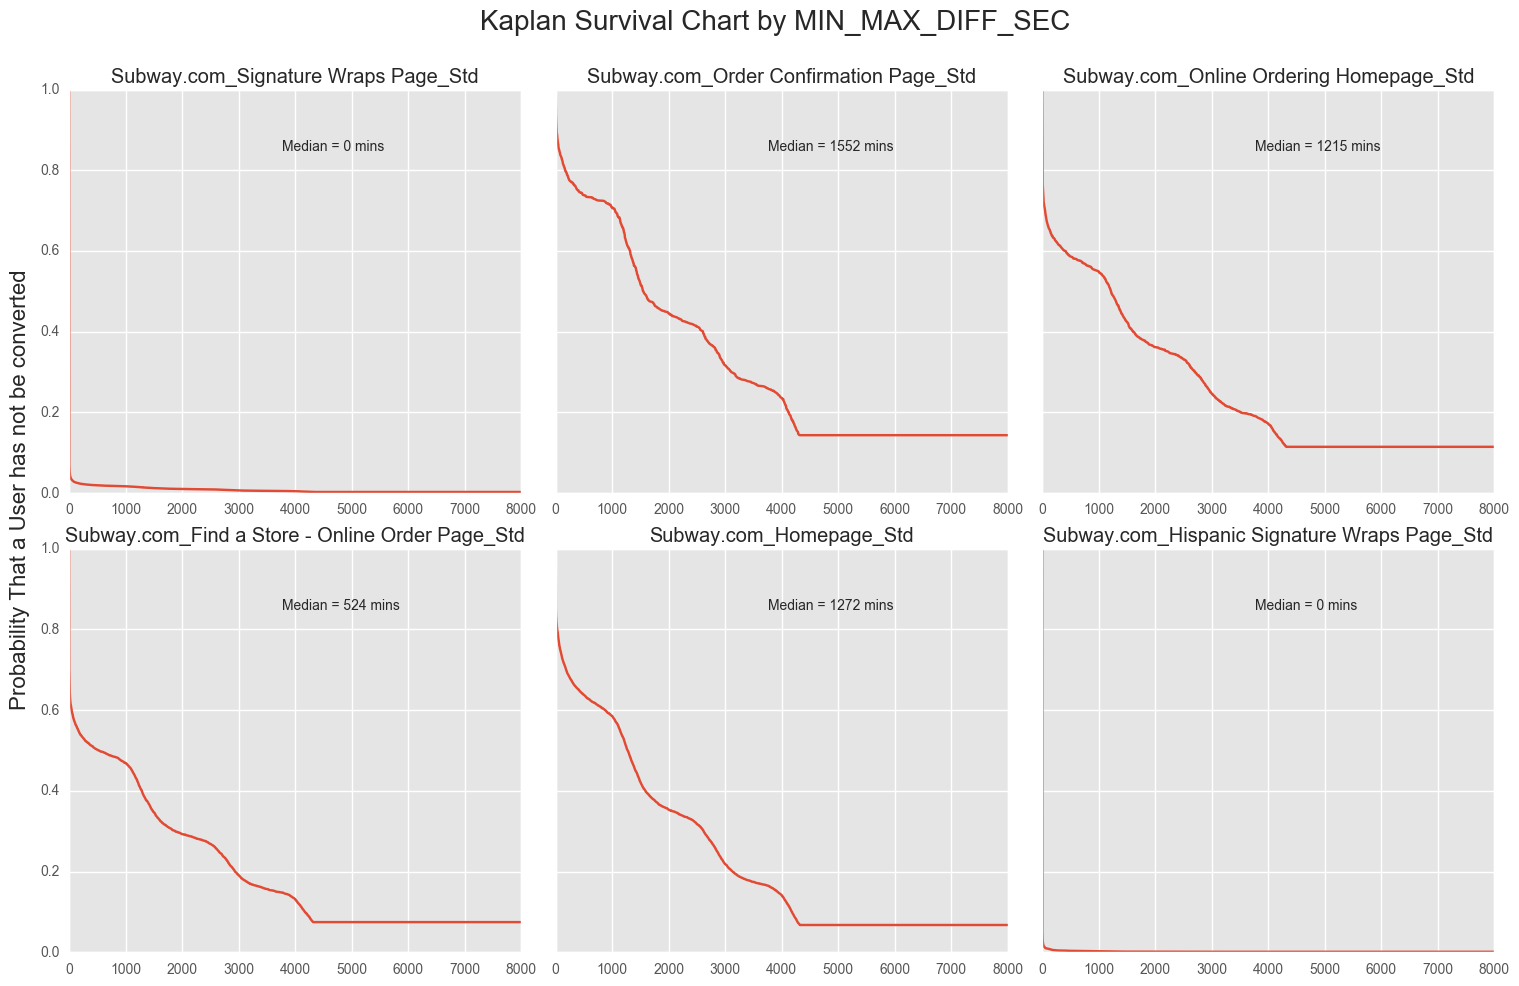

In [52]:
kaplan_plot('MIN_MAX_DIFF_SEC', 'Last_IMP_Converted',activity_list, df_lookback2)

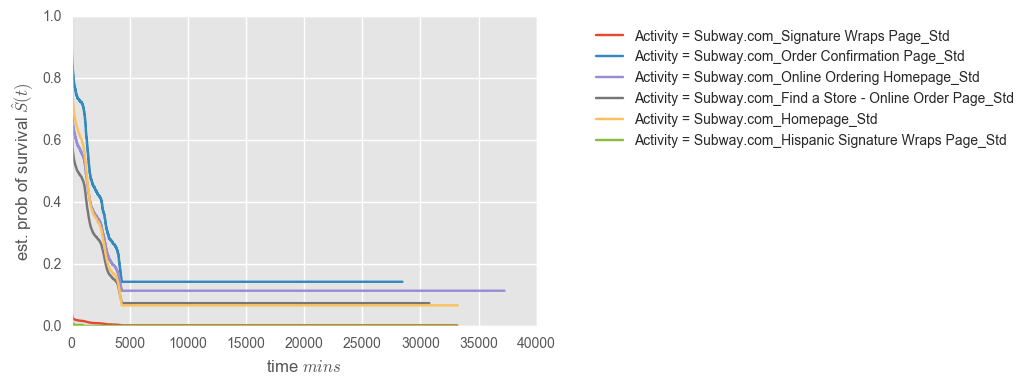

In [20]:
kmf_by_act = KaplanMeierFitter()
duration = df_lookback2.MIN_MAX_DIFF_SEC
observed = df_lookback2.Last_IMP_Converted

for act in activity_list:
    idx = df_lookback2.Activity == act
    kmf_by_act.fit(duration[idx], observed[idx])
    plt.step(kmf_by_act.timeline,kmf_by_act.survival_function_,
             label = 'Activity = %s' %act)
    plt.ylabel('est. prob of survival $\hat{S}(t)$')
    plt.xlabel('time $mins$')
    plt.legend(bbox_to_anchor = (1.1,1),loc = 'upper left')

In [21]:
import datetime as dt

In [22]:
df_lookback2.MIN_CONV_TIME = pd.to_datetime(df_lookback2.MIN_CONV_TIME)
df_lookback2.MAX_IMP_TIME = pd.to_datetime(df_lookback2.MAX_IMP_TIME)

In [23]:
df_lookback2['Hour'] = df_lookback2.MIN_CONV_TIME.dt.hour
df_lookback2['IMP_Hour'] = df_lookback2.MAX_IMP_TIME.dt.hour

In [24]:
df_lookback2['CONV_TIME_CATEGORY'] = np.where(((df_lookback2.Hour>=7) & (df_lookback2.Hour<10)),'Morning',
                                     np.where(((df_lookback2.Hour>=11) & (df_lookback2.Hour<14)),'Noon',
                                     np.where(((df_lookback2.Hour>=14) & (df_lookback2.Hour<=17)),'Afternoon',
                                     np.where(((df_lookback2.Hour>=17) & (df_lookback2.Hour<=20)),'Night', 'Other'))))

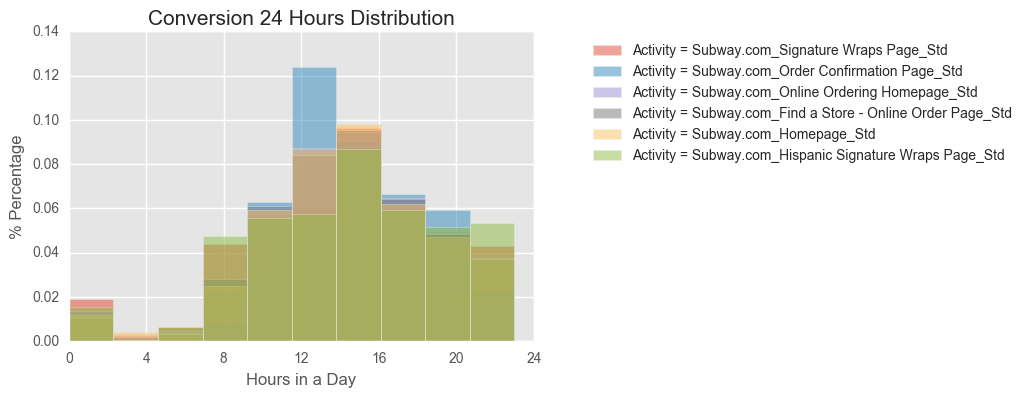

In [36]:
for act in activity_list:
    idx = df_lookback2.Activity == act
    plt.hist(df_lookback2[idx].Hour,alpha=0.5, normed=True, label='Activity = %s' %act)
    plt.legend(bbox_to_anchor=(1.1,1), loc="upper left")
    plt.xticks([0,4,8,12,16,20,24])
    plt.ylabel('% Percentage')
    plt.xlabel('Hours in a Day')
    plt.title("Conversion 24 Hours Distribution", fontsize='15')
    plt.savefig('hours_distribution1.png')

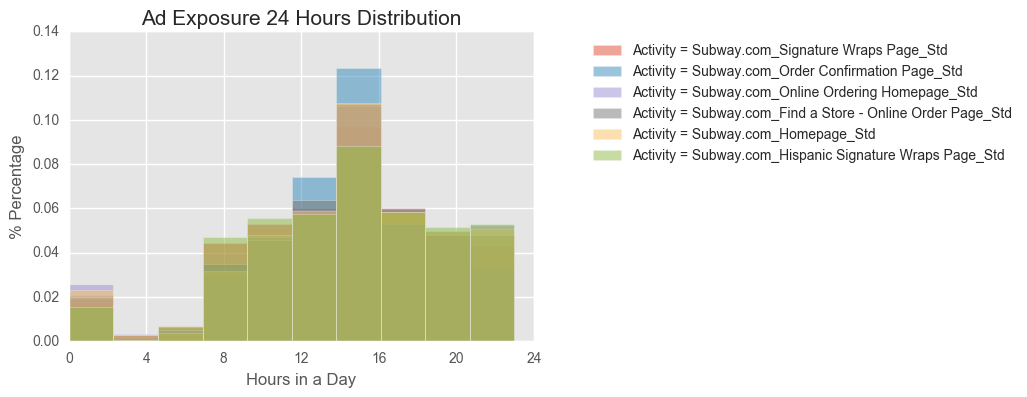

In [37]:
for act in activity_list:
    idx = df_lookback2.Activity == act
    plt.hist(df_lookback2[idx].IMP_Hour,alpha=0.5, normed=True, label='Activity = %s' %act)
    plt.legend(bbox_to_anchor=(1.1,1), loc="upper left")
    plt.xticks([0,4,8,12,16,20,24])
    plt.ylabel('% Percentage')
    plt.xlabel('Hours in a Day')
    plt.title("Ad Exposure 24 Hours Distribution", fontsize='15')
    plt.savefig('hours_distribution2.png')

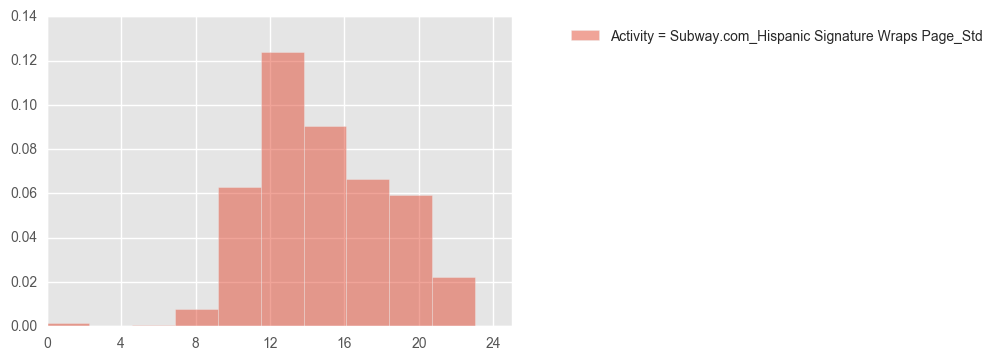

In [27]:
idx = df_lookback2.Activity == 'Subway.com_Order Confirmation Page_Std'
plt.hist(df_lookback2[idx].Hour,alpha=0.5, normed=True, label='Activity = %s' %act)
plt.legend(bbox_to_anchor=(1.1,1), loc="upper left")
plt.xticks([0,4,8,12,16,20,24])
plt.show()

#### After or Before Segment Survival  
1. 12 PM as Benchmark <br>
1.1 Before 12 PM -- 1, After 12 PM -- 0 <br>


In [48]:
df_lookback2['Exposed_After_Before'] = np.where(df_lookback2.IMP_Hour <= 12, 1, 0)

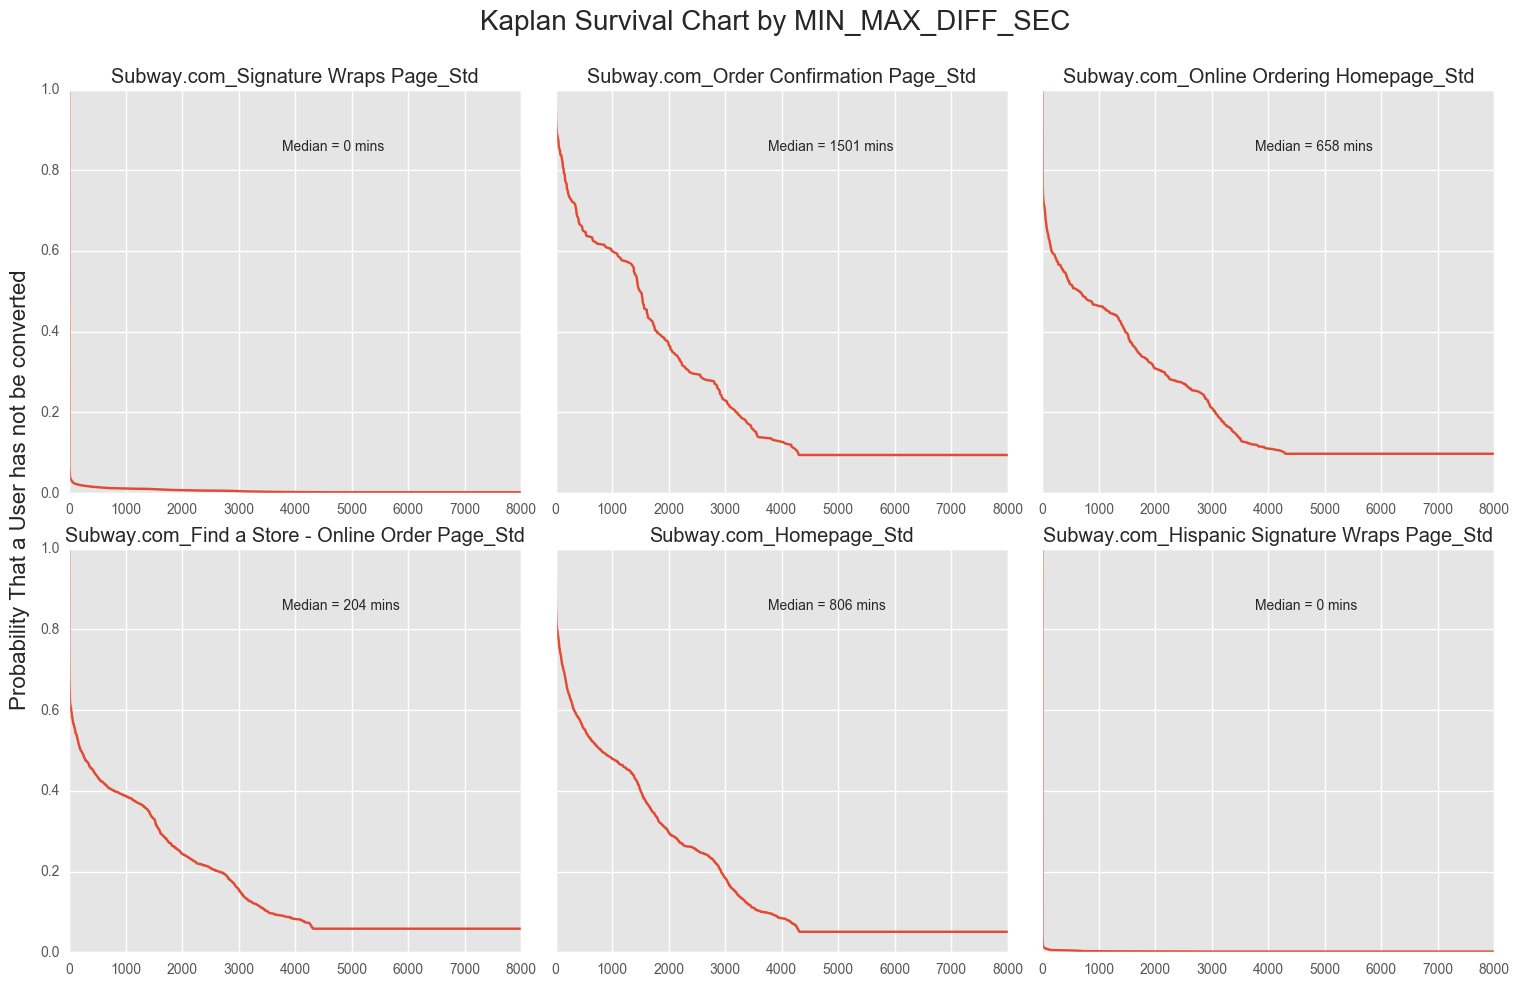

In [80]:
kaplan_plot('MIN_MAX_DIFF_SEC', 'Last_IMP_Converted',activity_list, df_lookback2[df_lookback2.Exposed_After_Before==1])

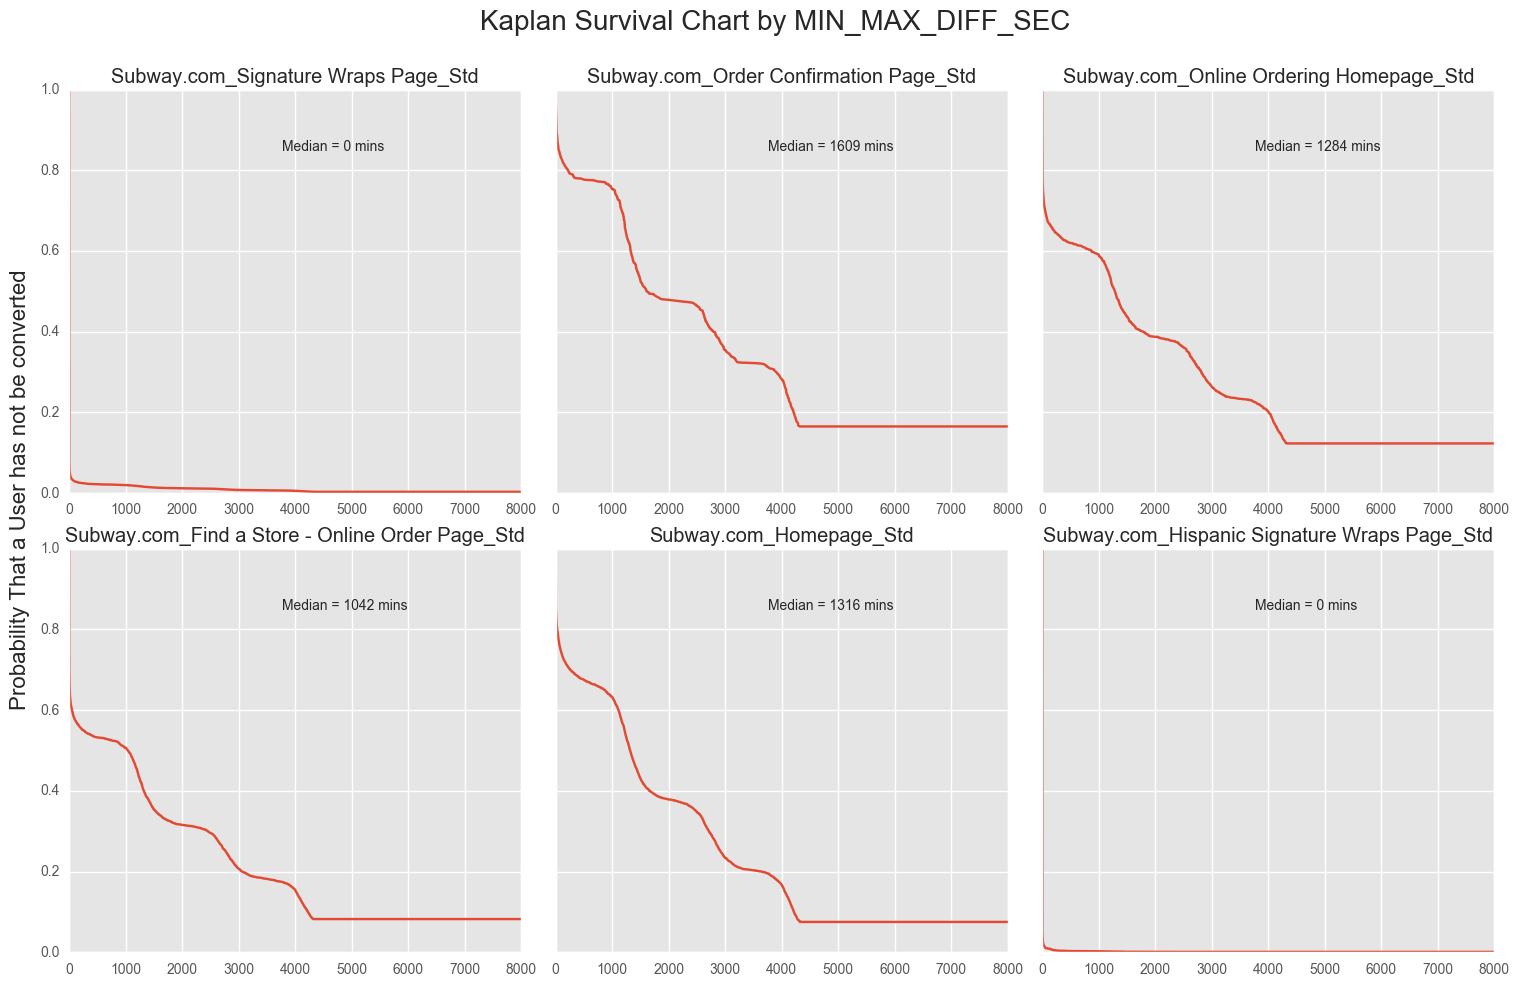

In [54]:
kaplan_plot('MIN_MAX_DIFF_SEC', 'Last_IMP_Converted',activity_list, df_lookback2[df_lookback2.Exposed_After_Before==0])

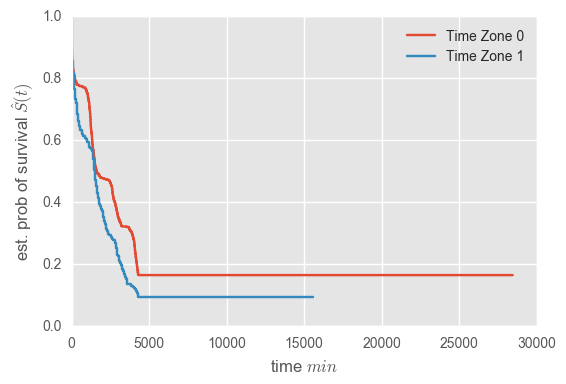

In [59]:
kmf_after_before = KaplanMeierFitter()
duration = df_lookback2.MIN_MAX_DIFF_SEC[df_lookback2.Activity == 'Subway.com_Order Confirmation Page_Std']
observed = df_lookback2.Last_IMP_Converted[df_lookback2.Activity == 'Subway.com_Order Confirmation Page_Std']

for time_zone in df_lookback2.Exposed_After_Before.unique().tolist():
    idx = df_lookback2.Exposed_After_Before == time_zone
    kmf_after_before.fit(duration[idx], observed[idx])
    plt.step(kmf_after_before.timeline, kmf_after_before.survival_function_,
            label = 'Time Zone {}'.format(time_zone))
    plt.ylabel('est. prob of survival $\hat{S}(t)$')
    plt.xlabel('time $min$')
    plt.legend()

In [60]:
df_lookback2.head()

,User_ID,Activity_ID,MIN_CONV_TIME,MIN_IMP_TIME,MAX_IMP_TIME,MIN_MIN_DIFF_SEC,MIN_MAX_DIFF_SEC,MIN_MIN_DIFF_DAY,MIN_MAX_DIFF_DAY,Num_of_IMPs_3days,Num_of_IMPs,Activity,Last_IMP_Converted,First_IMP_Converted,Hour,IMP_Hour,CONV_TIME_CATEGORY,Exposed_After_Before
28,AMsySZa8xS1ETzhj8QsksNvINUEM,7038525,2018-03-18 15:34:26.965445,2018-03-18 15:34:01.668387,2018-03-18 15:34:01.668387,0.416667,0.416667,0,0,1,1,Subway.com_Signature Wraps Page_Std,1,1,15,15,Afternoon,0
29,AMsySZZiAACcBd-qU8Qf9WBl-ghN,7038525,2018-03-22 16:46:36.303129,2018-03-22 16:45:57.876197,2018-03-22 16:45:57.876197,0.650000,0.650000,0,0,1,1,Subway.com_Signature Wraps Page_Std,1,1,16,16,Afternoon,0
30,AMsySZbBBVApYPTVcVaePNIglKxp,7038525,2018-03-22 22:56:17.924371,2018-03-22 22:56:09.505039,2018-03-22 22:56:09.505039,0.133333,0.133333,0,0,1,1,Subway.com_Signature Wraps Page_Std,1,1,22,22,Other,0
31,AMsySZYTI2vpDSE1tQIu_OoHtRJH,7038525,2018-03-14 21:04:12.334056,2018-03-14 21:03:32.633688,2018-03-14 21:03:32.633688,0.666667,0.666667,0,0,1,1,Subway.com_Signature Wraps Page_Std,1,1,21,21,Other,0
32,AMsySZZjjEmNH0NTYBoHAAYRXC8c,7038525,2018-03-23 14:05:52.807794,2018-03-23 14:05:27.763601,2018-03-23 14:05:27.763601,0.416667,0.416667,0,0,1,1,Subway.com_Signature Wraps Page_Std,1,1,14,14,Afternoon,0


In [67]:
df_order_confirmation = df_lookback2[df_lookback2.Activity == 'Subway.com_Order Confirmation Page_Std']
df_order_confirmation_after = df_order_confirmation[df_order_confirmation.Exposed_After_Before == 0]
df_order_confirmation_before = df_order_confirmation[df_order_confirmation.Exposed_After_Before == 1]

In [87]:
# Number of samples before or after 12 PM
df_order_confirmation.Exposed_After_Before.value_counts()

0    720
1    317
Name: Exposed_After_Before, dtype: int64

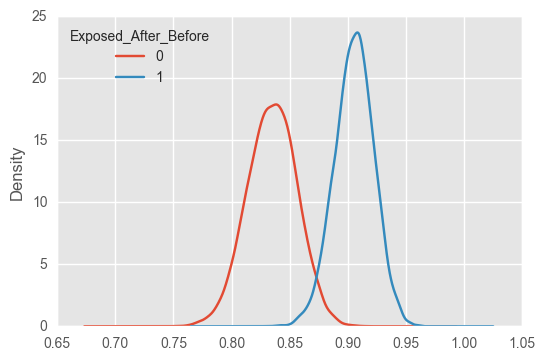

In [111]:
# Because unbalance of the data, apply bootstrapping to extract 300 samples for each group
## Apply 10,000 bootstrap
boot_list = []
for i in range(10000):
    boot_300 = df_order_confirmation.groupby('Exposed_After_Before').Last_IMP_Converted.apply(lambda s:s.sample(300,replace=True))
    boot_mean = boot_300.groupby(level = 0).mean()
    boot_list.append(boot_mean)

# Transforming the list to a DataFrame    
df_boot = pd.DataFrame(boot_list)

# A Kernel Density Estimate plot for bootstrapping distributions
df_boot.plot.kde()

In [112]:
df_boot['diff'] = df_boot[1] - df_boot[0]

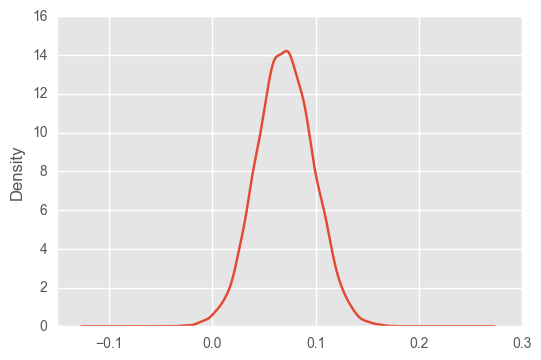

In [117]:
df_boot['diff'].plot.kde()

In [123]:
print ('95% Confidence Interval is between {} and {}'.format(df_boot['diff'].mean() - 1.96 * df_boot['diff'].std(),
                                                             df_boot['diff'].mean() + 1.96 * df_boot['diff'].std()))

95% Confidence Interval is between 0.01672461082032948 and 0.1242640558463396


In [79]:
afternoon_conversion_rate = (df_order_confirmation_after.Last_IMP_Converted == 1).sum()/df_order_confirmation_after.shape[0]
morning_conversion_rate = (df_order_confirmation_before.Last_IMP_Converted == 1).sum()/df_order_confirmation_before.shape[0]
print ('Exposed in the Afternoon (3 days Conversion Rate): {}'.format(afternoon_conversion_rate))
print ('Exposed in the Morning (3 days Conversion Rate): {}'.format(morning_conversion_rate))
print ('Relative Lift: {}'.format((morning_conversion_rate-afternoon_conversion_rate)*100) + '%')
print ('Absolute Lift: {}'.format(100 * (morning_conversion_rate-afternoon_conversion_rate)/afternoon_conversion_rate) + '%')

Exposed in the Afternoon (3 days Conversion Rate): 0.8347222222222223
Exposed in the Morning (3 days Conversion Rate): 0.9053627760252366
Relative Lift: 7.064055380301437%
Absolute Lift: 8.462761853272935%


### Frequency 

In [28]:
# Filter out lookback window more than 3 days
df_converted_within_3 = df_lookback2[df_lookback2.Num_of_IMPs_3days>0]

In [29]:
print ('Average Exposure Times before the Last IMP is: %s' %np.mean(df_converted_within_3.Num_of_IMPs_3days-1))
print ('Median Exposure Times before the Last IMP is: %s' %(df_converted_within_3.Num_of_IMPs_3days-1).median())

Average Exposure Times before the Last IMP is: 17.459851317276758
Median Exposure Times before the Last IMP is: 4.0


In [30]:
# Create a dictionary of mean and median
dict_mean_median = {}
mean_list = []
median_list = []
std_list = []
for act in activity_list:
    idx = df_converted_within_3.Activity == act
    mean_list.append(np.mean(df_converted_within_3.Num_of_IMPs_3days[idx]-1))
    median_list.append((df_converted_within_3.Num_of_IMPs_3days[idx]-1).median())
    std_list.append((df_converted_within_3.Num_of_IMPs_3days[idx]-1).std())
dict_mean_median['Mean'] = mean_list
dict_mean_median['Median'] = median_list
dict_mean_median['Standard Deviation'] = std_list
dict_mean_median['Activity'] = activity_list

In [31]:
df_mean_median = pd.DataFrame.from_dict(dict_mean_median)

In [32]:
df_mean_median

,Activity,Mean,Median,Standard Deviation
0,Subway.com_Signature Wraps Page_Std,17.932952,5.0,37.043213
1,Subway.com_Order Confirmation Page_Std,3.846154,1.0,8.405871
2,Subway.com_Online Ordering Homepage_Std,6.386374,1.0,19.260319
3,Subway.com_Find a Store - Online Order Page_Std,7.717256,1.0,22.428755
4,Subway.com_Homepage_Std,6.128838,1.0,19.268263
5,Subway.com_Hispanic Signature Wraps Page_Std,41.773119,10.0,71.325467


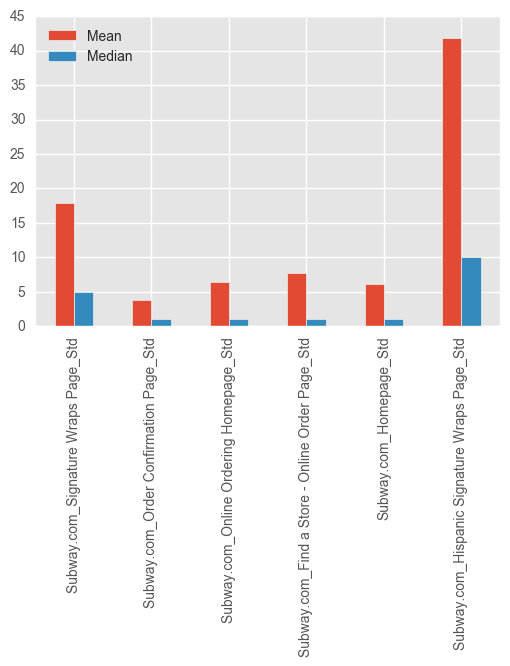

In [33]:
ax = df_mean_median[['Mean', 'Median']].plot(kind='bar')
ax.set_xticklabels(df_mean_median.Activity)
plt.show()

### Plotly 